## Outline

1. EDA on Donors choose
    * look for missing values
    * basic summary statistics
    * correlations
    * distribution of donations
    * time series of donations: donate more around holidays?
    * distribution of donation types —> spark DF to pandas DF
    * look at number completed vs number pending

## Raw Data

Thankfully [Donors Choose](http://www.donorschoose.org/) has gracefully (and transparently) opened up all of their data. There are five main datasets found [here](http://data.donorschoose.org/open-data/overview/):
* [Project Data (the main one we will use)](http://data.donorschoose.org/open-data/project-data/): All classroom projects that have been posted to the site, including lots of school info such as its NCES ID (government-issued), lat/long, and city/state/zip. Each row in the table is a classroom project. 
* [Donation Data (the largest and most specific)](http://data.donorschoose.org/open-data/donation-data/): All donations, including donor city, state, and partial-zip (when available). Each donation corresponds to a single classroom project so, for example, a donor can put 3 project donations in a check-out cart and pay for them with a single transaction.
* [Gistcard Data](http://data.donorschoose.org/open-data/giftcard-data/): All gift cards purchased by an individual donor through our public website, including donor and recipient city, state, and partial-zip (when available). 
* [Project Resources Data](http://data.donorschoose.org/open-data/project-resource-data/): All materials/resources requested for the classroom projects, including vendor name. Each record corresponds to a single requested material/resource from a specific vendor. 
* [Project Essay Data](http://data.donorschoose.org/open-data/project-essay-data/): Full text of the teacher-written requests accompanying all classroom projects. The heart of each teacher’s classroom project request is their written request, including a project title, a free-form essay or series of paragraphs answering a series of questions, and a summary of the materials/resources requested.

![relations](http://data.donorschoose.org/wp-content/uploads/2013/12/DonorsChoose-org-data-schema-04012011.png)

In [1]:
import pyspark as ps

In [2]:
# create a local Spark context
sc = ps.SparkContext('local')

# we can see that it uses all of the cores [*]
sc.master

u'local'

In [3]:
import os, ipdb

# need to get local path since we are reading local files
cwd = os.getcwd()

In [4]:
# need to download data from: https://s3.amazonaws.com/open_data/csv/opendata_projects.zip
rdd = sc.textFile('file://' + cwd + '/data/donors_choose/opendata_projects.csv')

In [5]:
rdd.count()

771930

In [6]:
rdd.first()

u'_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,vendor_shipping_charges,sales_tax,payment_processing_charges,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration'

In [7]:
rdd.take(2)

[u'_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,vendor_shipping_charges,sales_tax,payment_processing_charges,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration',
 u'"""e565fb42185c6e9f22806ad9d5ac8a77""","""2e17c8c91cb58132d8103a9aa8797e80""","""45e7ddbdd7023f1eb65a6cc028d7414f""",360009001332,40.841691,-73.875457,Bronx,NY,10460,urban,New 

In [8]:
header = rdd.first()

In [9]:
rdd_no_header = rdd.filter(lambda row: row != header)

In [10]:
rdd_no_header.first()

u'"""e565fb42185c6e9f22806ad9d5ac8a77""","""2e17c8c91cb58132d8103a9aa8797e80""","""45e7ddbdd7023f1eb65a6cc028d7414f""",360009001332,40.841691,-73.875457,Bronx,NY,10460,urban,New York City Dept Of Ed,Bronx,f,f,f,f,f,f,Mr.,f,f,Literacy,Literacy & Language,,,Books,highest poverty,Grades 9-12,,,,,280.02,341.49,0,308.00,1,f,f,completed,2007-03-08,2007-03-08,2007-03-08,2003-12-31'

In [11]:
rdd_no_header.count()

771929

In [12]:
rdd_csv = rdd_no_header.map(lambda row: row.split(',')) 

## Data Quality

In [13]:
# first quality check, consistent number of fields?
header_list = header.split(',')
columns_count = len(header_list)
columns_count

44

In [14]:
rdd_csv.map(lambda row: len(row) == columns_count).sum()

771894

In [15]:
rdd_csv.map(lambda row: len(row) != columns_count).sum()

35

In [16]:
class RowSplitException(Exception):
    pass

In [17]:
import pprint

def throw_exception(row):
    if len(row) != columns_count:
        row_zip = zip(header_list, row)
        message = pprint.pformat(row_zip)
        
        print row
        print message
        raise RowSplitException(message)
    else:
        pass

rdd_csv.foreach(throw_exception)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 8.0 failed 1 times, most recent failure: Lost task 0.0 in stage 8.0 (TID 44, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/pyspark/rdd.py", line 2330, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/pyspark/rdd.py", line 2330, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/pyspark/rdd.py", line 2330, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/pyspark/rdd.py", line 2330, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/pyspark/rdd.py", line 316, in func
    return f(iterator)
  File "/Users/jonathandinu/spark-1.4.1-bin-hadoop2.4/python/pyspark/rdd.py", line 731, in processPartition
    f(x)
  File "<ipython-input-17-38ffb2b4bfea>", line 10, in throw_exception
RowSplitException: [(u'_projectid', u'"""cf841ea7e1bda85b3426465238577311"""'),
 (u'_teacher_acctid', u'"""e4e5065e2512062b663cf799d6a8d95f"""'),
 (u'_schoolid', u'"""2e472567a2c3890e536302e1461c3a3e"""'),
 (u'school_ncesid', u'""'),
 (u'school_latitude', u'40.714550'),
 (u'school_longitude', u'-74.007125'),
 (u'school_city', u'"Bronx'),
 (u'school_state', u' N.Y."'),
 (u'school_zip', u'NY'),
 (u'school_metro', u'10473'),
 (u'school_district', u''),
 (u'school_county', u'Leadership Learning Support Organization'),
 (u'school_charter', u'Bronx'),
 (u'school_magnet', u'f'),
 (u'school_year_round', u'f'),
 (u'school_nlns', u'f'),
 (u'school_kipp', u'f'),
 (u'school_charter_ready_promise', u'f'),
 (u'teacher_prefix', u'f'),
 (u'teacher_teach_for_america', u'Mrs.'),
 (u'teacher_ny_teaching_fellow', u'f'),
 (u'primary_focus_subject', u'f'),
 (u'primary_focus_area', u'Literacy'),
 (u'secondary_focus_subject', u'Literacy & Language'),
 (u'secondary_focus_area', u''),
 (u'resource_type', u''),
 (u'poverty_level', u'Other'),
 (u'grade_level', u'highest poverty'),
 (u'vendor_shipping_charges', u'Grades PreK-2'),
 (u'sales_tax', u'20.88'),
 (u'payment_processing_charges', u'0.00'),
 (u'fulfillment_labor_materials', u'5.22'),
 (u'total_price_excluding_optional_support', u'17.00'),
 (u'total_price_including_optional_support', u'252.00'),
 (u'students_reached', u'307.32'),
 (u'total_donations', u'22'),
 (u'num_donors', u'0.00'),
 (u'eligible_double_your_impact_match', u'0'),
 (u'eligible_almost_home_match', u'f'),
 (u'funding_status', u'f'),
 (u'date_posted', u'expired'),
 (u'date_completed', u'2008-01-31'),
 (u'date_thank_you_packet_mailed', u''),
 (u'date_expiration', u'')]

	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:138)
	at org.apache.spark.api.python.PythonRDD$$anon$1.<init>(PythonRDD.scala:179)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:97)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:277)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:244)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:63)
	at org.apache.spark.scheduler.Task.run(Task.scala:70)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1273)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1264)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1263)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1263)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:730)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:730)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:730)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1457)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1418)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)


In [18]:
import csv

record = '45,3,27.1,Jonathan,Dinu,"Galvanize","San Francisco , CA", 26'

naive = record.split(',')
csv_lib = csv.reader(['45,3,27.1,Jonathan,Dinu,"Galvanize","San Francisco , CA", 26']).next()

print naive
print "Naive splitting creates {0} fields".format(len(naive))
print "\n"

print csv_lib
print "Using the built in CSV library creates {0} fields".format(len(csv_lib))

['45', '3', '27.1', 'Jonathan', 'Dinu', '"Galvanize"', '"San Francisco ', ' CA"', ' 26']
Naive splitting creates 9 fields


['45', '3', '27.1', 'Jonathan', 'Dinu', 'Galvanize', 'San Francisco , CA', ' 26']
Using the built in CSV library creates 8 fields


In [19]:
rdd_csv_corrrect = rdd_no_header.map(lambda line: csv.reader([line]).next())

In [20]:
rdd_csv_corrrect.foreach(throw_exception)
print "YAY it worked!"

YAY it worked!


## Lets look at how Spark can help us EDA

In [21]:
rdd_no_dups = rdd_csv_corrrect.map(lambda row: str(row)).distinct()

In [22]:
rdd_no_dups.count()

771929

In [23]:
# no duplicates in original RDD
rdd_csv_corrrect.map(lambda row: str(row)).distinct().count()

771929

In [24]:
# more easily access 'columns'
rdd_dict = rdd_csv_corrrect.map(lambda row: dict(zip(header_list, row)))
rdd_dict.first()

{u'_projectid': '"e565fb42185c6e9f22806ad9d5ac8a77"',
 u'_schoolid': '"45e7ddbdd7023f1eb65a6cc028d7414f"',
 u'_teacher_acctid': '"2e17c8c91cb58132d8103a9aa8797e80"',
 u'date_completed': '2007-03-08',
 u'date_expiration': '2003-12-31',
 u'date_posted': '2007-03-08',
 u'date_thank_you_packet_mailed': '2007-03-08',
 u'eligible_almost_home_match': 'f',
 u'eligible_double_your_impact_match': 'f',
 u'fulfillment_labor_materials': '',
 u'funding_status': 'completed',
 u'grade_level': 'Grades 9-12',
 u'num_donors': '1',
 u'payment_processing_charges': '',
 u'poverty_level': 'highest poverty',
 u'primary_focus_area': 'Literacy & Language',
 u'primary_focus_subject': 'Literacy',
 u'resource_type': 'Books',
 u'sales_tax': '',
 u'school_charter': 'f',
 u'school_charter_ready_promise': 'f',
 u'school_city': 'Bronx',
 u'school_county': 'Bronx',
 u'school_district': 'New York City Dept Of Ed',
 u'school_kipp': 'f',
 u'school_latitude': '40.841691',
 u'school_longitude': '-73.875457',
 u'school_magnet

## Unique Values

In [25]:
# HyperLogLog
rdd_dict.map(lambda row: row['_schoolid']).countApproxDistinct()

62989L

In [26]:
rdd_dict.map(lambda row: row['_schoolid']).distinct().count()

61402

With EDA approximate values are often good enough since you are just trying to get a sense of the data.  For example, what is the order of magnitude of counts or distinct values?

In addition to getting a sense for the cardinality of a field to understand how many potential values a given column could have, these types of distinct counts can be used to evaluate further methods to use.

If trying to visualize the distribution of a value that has very many distinct values, you might need to bucket your data. Or if you are trying to do a crosstab() you can only have so many distinct values.

In [27]:
# probably do not want to compute counts -> pandas.plot(kind='bar')
rdd_dict.map(lambda row: row['total_price_excluding_optional_support']).countApproxDistinct()

124692L

## Missing/Null Values

In [28]:
accum = sc.accumulator(0)

In [29]:
from collections import Counter

In [30]:
class CounterAccumulatorParam(ps.accumulators.AccumulatorParam):
    def zero(self, initialValue):
        return Counter()

    def addInPlace(self, v1, v2):
        v1 += v2
        return v1

In [31]:
accum = sc.accumulator(Counter(), CounterAccumulatorParam())

In [32]:
def count_null(record):
    global accum
    
    c = Counter()
    
    for key, value in record.items():
            # since columns are initially strings
            # empty string signals missing value
            if value == '':
                c[key] += 1
                
    accum.add(c)

In [33]:
rdd_dict.foreach(count_null)

In [34]:
accum.value

Counter({u'date_thank_you_packet_mailed': 305004, u'date_completed': 253218, u'secondary_focus_subject': 238255, u'secondary_focus_area': 238255, u'school_metro': 95180, u'school_ncesid': 50973, u'payment_processing_charges': 35082, u'vendor_shipping_charges': 35082, u'fulfillment_labor_materials': 35082, u'sales_tax': 35082, u'school_district': 918, u'date_expiration': 208, u'students_reached': 150, u'resource_type': 48, u'primary_focus_subject': 42, u'primary_focus_area': 42, u'grade_level': 33, u'teacher_prefix': 20, u'school_county': 18, u'school_zip': 4})

## Type conversion

Spark is somewhat defensive in its typing, when you read in a textFile it well... assumes everything is text (i.e. Strings).  And with its type conversions, you either need to explicitly cast types in Spark, or convert to the appropriate type in Python through an RDD map.  In our case we are going to leverage the power of Spark and also to be sure of type parity we can use the same specification in our schema in our casting funciton.

Somewhat awkwardly the default loading function cannot read in CSV.  If we want to specify the schema we can either: 
* convert the data to JSON and use the JSON loader with a schema specified
* use an RDD which we transform into a format to create a dataframe

I will show both here, but in the future we will use the SparkCSV module which eleviates the JSON trick.  Converting data type columns is useful however (though for an entire dataset can be combersome which is why we won't do it in the future) and here it will circumvent the need to copy our data file.

In [35]:
from pyspark.sql.types import *
from datetime import datetime

In [36]:
# rdd value_counts()
rdd_dict.map(lambda d: (d['teacher_ny_teaching_fellow'], 1)).reduceByKey(lambda a, b: a + b).collect()

[('t', 12184), ('f', 759745)]

Given that our dataset represents Booleans as 't'/'f' strings and dates are simply strings we need to parse each column to convert it to the appropriate Python type beofre we can cast it to a Spark dataframe with a schema.

Fortunately the cast mappings are somewhat consistent across columns.  For ID columns we want to strip the quotes.

In [37]:
def quote_strip(field):
    return field.strip('"')

In [38]:
from datetime import datetime

# http://strftime.org/
def date_parse(datestring):
    return None if datestring == '' else str(datetime.strptime(datestring, '%Y-%m-%d'))

In [39]:
def boolean_map(field):
    if field == 't':
        return True
    elif field == 'f':
        return False
    else:
        None

For the other fields we simply need to do a type conversion (`int()` or `float()`). To make this somewhat manageable across so many columns (and to make sure our schema is consistent), I have defined the Spark schema apriori.  We will use this to programmatically convert our columns.  Since we will do this on the fly we need a lookup table for which conversion function to apply.

In [40]:
type_conversion_func = {
    'id': quote_strip,
    'date': date_parse,
    'boolean': boolean_map,
    'float': lambda x: None if x == '' else float(x),
    'integer': lambda x: None if x == '' else int(x),
    'string': lambda x: None if x == '' else x
}

In [41]:
type_conversion_func['float']('10.2')

10.2

In [42]:
# Hand specified schema
types = [
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    FloatType(),
    FloatType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    BooleanType(),
    BooleanType(),
    BooleanType(),
    BooleanType(),
    BooleanType(),
    BooleanType(),
    StringType(),
    BooleanType(),
    BooleanType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    StringType(),
    FloatType(),
    FloatType(),
    FloatType(),
    FloatType(),
    FloatType(),
    FloatType(),
    FloatType(),
    FloatType(),
    FloatType(),
    BooleanType(),
    BooleanType(),
    StringType(),
    DateType(),
    DateType(),
    DateType(),
    DateType()
]

Now this is where we will use a little Python magic to intelligently introspect our collumns and apply the proper transform. Observe that:

In [43]:
ft = FloatType()

In [44]:
ft.typeName()

'float'

In [45]:
types[3].typeName()

'string'

In [46]:
column_type_lookup = dict(zip(header_list, types))
column_type_lookup

{u'_projectid': StringType,
 u'_schoolid': StringType,
 u'_teacher_acctid': StringType,
 u'date_completed': DateType,
 u'date_expiration': DateType,
 u'date_posted': DateType,
 u'date_thank_you_packet_mailed': DateType,
 u'eligible_almost_home_match': BooleanType,
 u'eligible_double_your_impact_match': BooleanType,
 u'fulfillment_labor_materials': FloatType,
 u'funding_status': StringType,
 u'grade_level': StringType,
 u'num_donors': FloatType,
 u'payment_processing_charges': FloatType,
 u'poverty_level': StringType,
 u'primary_focus_area': StringType,
 u'primary_focus_subject': StringType,
 u'resource_type': StringType,
 u'sales_tax': FloatType,
 u'school_charter': BooleanType,
 u'school_charter_ready_promise': BooleanType,
 u'school_city': StringType,
 u'school_county': StringType,
 u'school_district': StringType,
 u'school_kipp': BooleanType,
 u'school_latitude': FloatType,
 u'school_longitude': FloatType,
 u'school_magnet': BooleanType,
 u'school_metro': StringType,
 u'school_ncesi

In [47]:
import json

def convert_types(d):
    for field in d:
        if field[0] == "_":
            transform = type_conversion_func['id']
        else:
            transform = type_conversion_func[column_type_lookup[field].typeName()]
        
        d[field] = transform(d[field])
        
    return json.dumps(d)

In [48]:
rdd_typed = rdd_dict.map(convert_types)

In [49]:
rdd_typed.take(1)

['{"total_price_including_optional_support": 341.49, "school_district": "New York City Dept Of Ed", "secondary_focus_area": null, "primary_focus_area": "Literacy & Language", "school_latitude": 40.841691, "date_thank_you_packet_mailed": "2007-03-08 00:00:00", "school_year_round": false, "school_charter": false, "_projectid": "e565fb42185c6e9f22806ad9d5ac8a77", "_schoolid": "45e7ddbdd7023f1eb65a6cc028d7414f", "teacher_teach_for_america": false, "school_magnet": false, "school_kipp": false, "date_posted": "2007-03-08 00:00:00", "payment_processing_charges": null, "grade_level": "Grades 9-12", "primary_focus_subject": "Literacy", "school_ncesid": "360009001332", "poverty_level": "highest poverty", "school_state": "NY", "school_charter_ready_promise": false, "teacher_prefix": "Mr.", "school_county": "Bronx", "date_expiration": "2003-12-31 00:00:00", "vendor_shipping_charges": null, "students_reached": 0.0, "school_city": "Bronx", "num_donors": 1.0, "eligible_double_your_impact_match": fals

In [50]:
from pyspark.sql import Row

# create SQLContext for DataFrame
sqlContext = ps.HiveContext(sc)

In [51]:
# infer schema
df = sqlContext.jsonRDD(rdd_typed)

In [52]:
# unfortunately the date types didn't get inferrred
df.printSchema()

root
 |-- _projectid: string (nullable = true)
 |-- _schoolid: string (nullable = true)
 |-- _teacher_acctid: string (nullable = true)
 |-- date_completed: string (nullable = true)
 |-- date_expiration: string (nullable = true)
 |-- date_posted: string (nullable = true)
 |-- date_thank_you_packet_mailed: string (nullable = true)
 |-- eligible_almost_home_match: boolean (nullable = true)
 |-- eligible_double_your_impact_match: boolean (nullable = true)
 |-- fulfillment_labor_materials: double (nullable = true)
 |-- funding_status: string (nullable = true)
 |-- grade_level: string (nullable = true)
 |-- num_donors: double (nullable = true)
 |-- payment_processing_charges: double (nullable = true)
 |-- poverty_level: string (nullable = true)
 |-- primary_focus_area: string (nullable = true)
 |-- primary_focus_subject: string (nullable = true)
 |-- resource_type: string (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- school_charter: boolean (nullable = true)
 |-- school_cha

In [53]:
structs = map(lambda x: StructField(*x), zip(header_list, types))

In [54]:
schema = StructType(structs)
schema.fields

[StructField(_projectid,StringType,true),
 StructField(_teacher_acctid,StringType,true),
 StructField(_schoolid,StringType,true),
 StructField(school_ncesid,StringType,true),
 StructField(school_latitude,FloatType,true),
 StructField(school_longitude,FloatType,true),
 StructField(school_city,StringType,true),
 StructField(school_state,StringType,true),
 StructField(school_zip,StringType,true),
 StructField(school_metro,StringType,true),
 StructField(school_district,StringType,true),
 StructField(school_county,StringType,true),
 StructField(school_charter,BooleanType,true),
 StructField(school_magnet,BooleanType,true),
 StructField(school_year_round,BooleanType,true),
 StructField(school_nlns,BooleanType,true),
 StructField(school_kipp,BooleanType,true),
 StructField(school_charter_ready_promise,BooleanType,true),
 StructField(teacher_prefix,StringType,true),
 StructField(teacher_teach_for_america,BooleanType,true),
 StructField(teacher_ny_teaching_fellow,BooleanType,true),
 StructField

In [55]:
# force schema
df_force = sqlContext.jsonRDD(rdd_typed, schema=schema)

Now I have already converted this RDD into a dataframe in a similar manner to how we created a dataframe in the SQL video.  If you would like to see how I did it, please refer to the exercise notebook.

In [56]:
df_force.printSchema()

root
 |-- _projectid: string (nullable = true)
 |-- _teacher_acctid: string (nullable = true)
 |-- _schoolid: string (nullable = true)
 |-- school_ncesid: string (nullable = true)
 |-- school_latitude: float (nullable = true)
 |-- school_longitude: float (nullable = true)
 |-- school_city: string (nullable = true)
 |-- school_state: string (nullable = true)
 |-- school_zip: string (nullable = true)
 |-- school_metro: string (nullable = true)
 |-- school_district: string (nullable = true)
 |-- school_county: string (nullable = true)
 |-- school_charter: boolean (nullable = true)
 |-- school_magnet: boolean (nullable = true)
 |-- school_year_round: boolean (nullable = true)
 |-- school_nlns: boolean (nullable = true)
 |-- school_kipp: boolean (nullable = true)
 |-- school_charter_ready_promise: boolean (nullable = true)
 |-- teacher_prefix: string (nullable = true)
 |-- teacher_teach_for_america: boolean (nullable = true)
 |-- teacher_ny_teaching_fellow: boolean (nullable = true)
 |-- pr

In [57]:
# when schema forced, dates convert correctly
df_force.first()

Row(_projectid=u'e565fb42185c6e9f22806ad9d5ac8a77', _teacher_acctid=u'2e17c8c91cb58132d8103a9aa8797e80', _schoolid=u'45e7ddbdd7023f1eb65a6cc028d7414f', school_ncesid=u'360009001332', school_latitude=40.84169006347656, school_longitude=-73.87545776367188, school_city=u'Bronx', school_state=u'NY', school_zip=u'10460', school_metro=u'urban', school_district=u'New York City Dept Of Ed', school_county=u'Bronx', school_charter=False, school_magnet=False, school_year_round=False, school_nlns=False, school_kipp=False, school_charter_ready_promise=False, teacher_prefix=u'Mr.', teacher_teach_for_america=False, teacher_ny_teaching_fellow=False, primary_focus_subject=u'Literacy', primary_focus_area=u'Literacy & Language', secondary_focus_subject=None, secondary_focus_area=None, resource_type=u'Books', poverty_level=u'highest poverty', grade_level=u'Grades 9-12', vendor_shipping_charges=None, sales_tax=None, payment_processing_charges=None, fulfillment_labor_materials=None, total_price_excluding_op

In [58]:
df_force.show()

+--------------------+--------------------+--------------------+-------------+---------------+----------------+-----------+------------+----------+------------+--------------------+--------------------+--------------+-------------+-----------------+-----------+-----------+----------------------------+--------------+-------------------------+--------------------------+---------------------+-------------------+-----------------------+--------------------+-------------+---------------+-----------+-----------------------+---------+--------------------------+---------------------------+--------------------------------------+--------------------------------------+----------------+---------------+----------+---------------------------------+--------------------------+--------------+-----------+--------------+----------------------------+---------------+
|          _projectid|     _teacher_acctid|           _schoolid|school_ncesid|school_latitude|school_longitude|school_city|school_state|schoo

In [59]:
# subselect relevant columns
df_subselect = df_force.select('school_city', 'primary_focus_area', \
                               df_force['resource_type'].alias('resource'), \
                               'poverty_level','grade_level', \
                               df_force['total_price_excluding_optional_support'].alias('p_exclude'), \
                               df_force['total_donations'].alias('total_d'), \
                               df_force['funding_status'].alias('status'))

In [60]:
# formats nicely now
df_subselect.show()

+-----------+-------------------+----------+---------------+-----------+---------+-------+---------+
|school_city| primary_focus_area|  resource|  poverty_level|grade_level|p_exclude|total_d|   status|
+-----------+-------------------+----------+---------------+-----------+---------+-------+---------+
|      Bronx|Literacy & Language|     Books|highest poverty|Grades 9-12|   280.02|  308.0|completed|
|      Bronx|     Math & Science|Technology|highest poverty|Grades 9-12|   299.95|  329.0|completed|
|   New York|   Music & The Arts|     Trips|highest poverty|Grades 9-12|    290.0|  319.0|completed|
|      Bronx|   Applied Learning|     Books|highest poverty|Grades 9-12|   348.04|  382.0|completed|
|      Bronx|   Applied Learning|     Books|highest poverty|Grades 9-12|   297.39|  327.0|completed|
|      Bronx|Literacy & Language|     Books|highest poverty|Grades 9-12|   388.39| 388.39|completed|
|      Bronx|   History & Civics|Technology|highest poverty|Grades 9-12|    402.0|  402.0|c

## Null Values Checks (take 2)

In [61]:
df_force.filter(df_force['students_reached'].isNull()).select('students_reached', 'funding_status').collect()

[Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'expired'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, funding_status=u'completed'),
 Row(students_reached=None, fu

In [62]:
df_no_null = df_force.fillna(0, ['students_reached'])

## Frequent Items

In [63]:
freq_items = df_no_null.freqItems(['school_city', 'primary_focus_area', \
                                     'grade_level', 'poverty_level','resource_type'], 0.7).collect()

In [64]:
freq_items[0]

Row(school_city_freqItems=[u'Los Angeles'], primary_focus_area_freqItems=[u'Literacy & Language'], grade_level_freqItems=[u'Grades PreK-2'], poverty_level_freqItems=[u'highest poverty'], resource_type_freqItems=[u'Supplies'])

In [65]:
df_no_null.freqItems(['num_donors'], .3).collect()[0]

Row(num_donors_freqItems=[2.0, 1.0, 0.0])

## Distributions

In [66]:
df_no_null.groupby('funding_status').count().show()

+--------------+------+
|funding_status| count|
+--------------+------+
|     completed|515005|
|   reallocated|  7200|
|       expired|207853|
|          live| 41871|
+--------------+------+



In [67]:
df_complete = df_no_null.filter(df_no_null['funding_status'] == 'completed')
df_expired = df_no_null.filter(df_no_null['funding_status'] == 'expired')

In [68]:
df_complete.write.json('file://' + cwd + '/data/donors_choose/opendata_completed.json')
df_expired.write.json('file://' + cwd + '/data/donors_choose/opendata_expired.json')

In [69]:
df_complete.groupby('num_donors').count().write.json('file://' + cwd + '/data/donors_choose/agg/num_donors_completed.json')
df_expired.groupby('num_donors').count().write.json('file://' + cwd + '/data/donors_choose/agg/num_donors_expired.json')

In [70]:
!du -h data/

256M	data//airline-data
 50M	data//churn
904K	data//donors_choose/agg/num_donors_completed.json
904K	data//donors_choose/agg/num_donors_expired.json
1.8M	data//donors_choose/agg
679M	data//donors_choose/opendata_completed.json
259M	data//donors_choose/opendata_expired.json
2.4G	data//donors_choose
8.0M	data//readychef
2.7G	data/


In [71]:
df_no_null.select('total_donations', 'num_donors', 'students_reached', \
                  df_no_null['total_price_excluding_optional_support'].alias('p_exclude'), \
                  df_no_null['total_price_including_optional_support'].alias('p_include')) \
          .describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|   total_donations|       num_donors|  students_reached|         p_exclude|         p_include|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|            771929|           771929|            771929|            771929|            771929|
|   mean|370.85023398481707|4.264279486843997| 96.69740740404882| 569.6223687446723|  676.180708551764|
| stddev| 733.4647726421459|6.132976060232441|2118.3875384029384|11763.955807309705|14344.347534777195|
|    min|               0.0|              0.0|               0.0|               0.0|               0.0|
|    max|          244778.0|            521.0|          999999.0|       1.0250017E7|       1.2500021E7|
+-------+------------------+-----------------+------------------+------------------+------------------+



In [72]:
price_rdd = df_no_null.select('total_price_excluding_optional_support').rdd.map(lambda r: r.asDict().values()[0])

In [73]:
# massive outliers, will skew histogram buckets
outliers = price_rdd.top(3)
outliers

[10250017.0, 1000000.0, 437212.0]

In [74]:
# for continuous columns we can use Histogram RDD function
hist = price_rdd.filter(lambda x: x not in outliers).histogram(100)

In [75]:
hist

([0.0,
  1397.2540625,
  2794.508125,
  4191.7621874999995,
  5589.01625,
  6986.2703125,
  8383.524374999999,
  9780.7784375,
  11178.0325,
  12575.2865625,
  13972.540625,
  15369.7946875,
  16767.048749999998,
  18164.3028125,
  19561.556875,
  20958.8109375,
  22356.065,
  23753.3190625,
  25150.573125,
  26547.8271875,
  27945.08125,
  29342.3353125,
  30739.589375,
  32136.8434375,
  33534.097499999996,
  34931.3515625,
  36328.605625,
  37725.8596875,
  39123.11375,
  40520.3678125,
  41917.621875,
  43314.8759375,
  44712.13,
  46109.384062499994,
  47506.638125,
  48903.892187499994,
  50301.14625,
  51698.400312499994,
  53095.654375,
  54492.908437499995,
  55890.1625,
  57287.416562499995,
  58684.670625,
  60081.924687499995,
  61479.17875,
  62876.432812499996,
  64273.686875,
  65670.9409375,
  67068.19499999999,
  68465.44906249999,
  69862.703125,
  71259.9571875,
  72657.21125,
  74054.46531249999,
  75451.719375,
  76848.9734375,
  78246.2275,
  79643.48156249999,
  

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [79]:
def plot_rdd_hist(hist):
    idx = []

    for i in range(len(hist[0]) - 1):
        idx.append((hist[0][i] + hist[0][i+1])/ 2)
        
    pd.DataFrame({'counts': hist[1], 'index': idx}).set_index('index').plot(figsize=(16,5))

In [80]:
cheap_histogram = price_rdd.filter(lambda x: x < 5000).histogram(100)

In [81]:
cheap_histogram

([0.0,
  49.9906982421875,
  99.981396484375,
  149.9720947265625,
  199.96279296875,
  249.9534912109375,
  299.944189453125,
  349.9348876953125,
  399.9255859375,
  449.91628417968747,
  499.906982421875,
  549.8976806640625,
  599.88837890625,
  649.8790771484374,
  699.869775390625,
  749.8604736328125,
  799.851171875,
  849.8418701171875,
  899.8325683593749,
  949.8232666015625,
  999.81396484375,
  1049.8046630859374,
  1099.795361328125,
  1149.7860595703125,
  1199.7767578125,
  1249.7674560546875,
  1299.7581542968749,
  1349.7488525390625,
  1399.73955078125,
  1449.7302490234374,
  1499.720947265625,
  1549.7116455078124,
  1599.70234375,
  1649.6930419921875,
  1699.683740234375,
  1749.6744384765625,
  1799.6651367187499,
  1849.6558349609375,
  1899.646533203125,
  1949.6372314453124,
  1999.6279296875,
  2049.6186279296876,
  2099.6093261718747,
  2149.6000244140623,
  2199.59072265625,
  2249.5814208984375,
  2299.572119140625,
  2349.562817382812,
  2399.553515625,


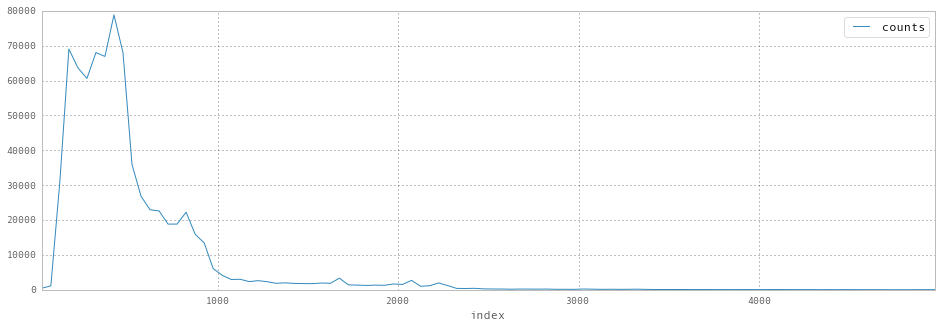

In [82]:
plot_rdd_hist(cheap_histogram)

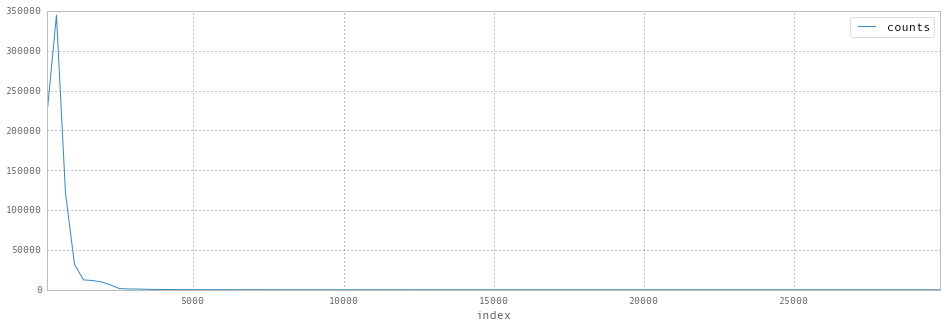

In [83]:
plot_rdd_hist(price_rdd.filter(lambda x: x < 30000).histogram(100))

The true power of Spark comes when we start passing data and operations between the local driver and the Spark context.  In doing so we can combine operations that are most efficient in Spark on a cluster with local methods that operate on smaller data.  

Here we are using Spark to do the heavy lifting of creating distributiions of the relevant queries, and then explore/visualize the condensed data with pandas and matplotlib locally. 

> For an example of passing these results to a client side D3.js interactive chart see the following: http://bl.ocks.org/Jay-Oh-eN/c532c8703547cf148006 


In [84]:
from IPython.display import IFrame

IFrame('http://bl.ocks.org/Jay-Oh-eN/raw/c532c8703547cf148006/d7c0db2150bdde2a56acce2456a5bbe19527a79b/', width=960, height=500)

In [85]:
def spark_histogram(df, column):
    donor_counts = df.groupby(column).count()
    donor_df = donor_counts.toPandas()
    donor_df[column] = donor_df.num_donors.astype(float)
    return donor_df.sort(column).set_index(column).iloc[:50,:].plot(kind='bar', figsize=(14,5))

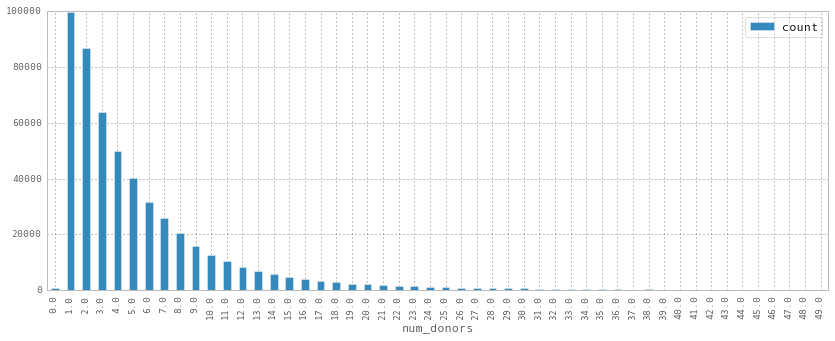

In [86]:
spark_histogram(df_complete, 'num_donors')

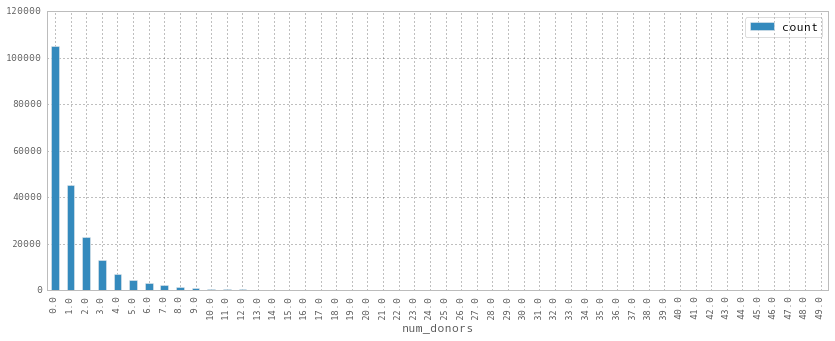

In [87]:
spark_histogram(df_expired, 'num_donors')

## Interactions

In [88]:
# categorical/boolean fields can give valuable facets (crosstabs)
df_no_null.crosstab('school_charter', 'funding_status').show()
df_no_null.crosstab('school_magnet', 'funding_status').show()
df_no_null.crosstab('school_metro', 'funding_status').show()
df_no_null.crosstab('poverty_level', 'funding_status').show()
df_no_null.crosstab('grade_level', 'funding_status').show()

+-----------------------------+-------+-----+---------+-----------+
|school_charter_funding_status|expired| live|completed|reallocated|
+-----------------------------+-------+-----+---------+-----------+
|                        false| 191960|38509|   465558|       6297|
|                         true|  15893| 3362|    49447|        903|
+-----------------------------+-------+-----+---------+-----------+

+----------------------------+-------+-----+---------+-----------+
|school_magnet_funding_status|expired| live|completed|reallocated|
+----------------------------+-------+-----+---------+-----------+
|                       false| 190178|38690|   465711|       6483|
|                        true|  17675| 3181|    49294|        717|
+----------------------------+-------+-----+---------+-----------+

+---------------------------+-------+---------+-----+-----------+
|school_metro_funding_status|expired|completed| live|reallocated|
+---------------------------+-------+---------+-----+---

In [89]:
df_no_null.crosstab('resource_type', 'funding_status').show()
df_no_null.crosstab('primary_focus_area', 'resource_type').show()

+----------------------------+-----+---------+-----------+-------+
|resource_type_funding_status| live|completed|reallocated|expired|
+----------------------------+-----+---------+-----------+-------+
|                        null|    2|       28|          0|     18|
|                       Other| 4542|    54610|        747|  22550|
|                       Books| 5982|   118810|       1527|  34554|
|                    Visitors|  102|      806|          6|    341|
|                    Supplies|11939|   185870|       2602|  63406|
|                       Trips|  347|     4381|         62|   1474|
|                  Technology|18957|   150500|       2256|  85510|
+----------------------------+-----+---------+-----------+-------+

+--------------------------------+-----+--------+-----+----------+------+--------+----+
|primary_focus_area_resource_type|Trips|Visitors|Other|Technology| Books|Supplies|null|
+--------------------------------+-----+--------+-----+----------+------+--------+----

In [90]:
df_no_null.stat.corr('total_price_excluding_optional_support', 'num_donors')

0.007004254706419042

In [91]:
df_no_null.stat.corr('total_price_excluding_optional_support', 'students_reached')

0.0006159991686679948

In [92]:
df_no_null.stat.corr('total_price_excluding_optional_support', 'total_price_including_optional_support')

0.9999972199123168